# Analysis for the floor control detection (FCD) model and competitor models

This notebook analyses the predictions of the FCD model and the competitor models discussed in the paper and show how they are compared over a few performance measurements. It also includes some stats about the dataset and the annotated floor properties, and an optimised FCD model for highest accuracy.

In [1]:
import itertools
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyjags
from scipy import optimize as soptimize

import predict_fcd
import utils.annotated_floor
import utils.iteration
import utils.mcmc_plot
import utils.path

In [2]:
%load_ext autoreload

%autoreload 2

plt.style.use('ggplot')
plt.rcParams.update({'axes.titlesize': 'large'})
np.random.seed(1234)

In [3]:
FEATURES_DIR = pathlib.Path('features')
PREDICTIONS_DIR = pathlib.Path('predictions')

ANALYSIS_SAMPLE_RATE = 10
SAMPLE_RATE = {
    'fcd': 50,
    'optimised_fcd': 50,
    'lstm': 20,
    'partial_lstm': 20,
    'vad': 50,
    'random': ANALYSIS_SAMPLE_RATE,
}
MODELS = list(SAMPLE_RATE.keys())

DEFAULT_FCD_PARAMS = (0.35, 0.1)
OPTIMISED_FCD_PARAMS = (1.78924915, 1.06722576)  # Overriden by lengthy optimisation below

CHAINS = 4
ITERATIONS = 10_000

# Utilities

Utility functions and generator functions that are used throughout the code and use the constants declared above. More utilities are imported from the `util` package. These are considered more generic.

### General utilities

In [4]:
def array_to_series(x, name, sample_rate):
    '''
    Convert a numpy array to a pandas series
    with time index.
    '''
    x = x[::sample_rate // ANALYSIS_SAMPLE_RATE]
    return pd.Series(
        x,
        index=np.arange(len(x)) / ANALYSIS_SAMPLE_RATE,
        name=name,
    )

In [5]:
def utterances_to_floor(utterances_df):
    '''
    Calculate the floor timeseries from a dataframe
    of utterances (every row has start_time, end_time,
    and participant).
    '''
    return array_to_series(
        list(
            utils.annotated_floor.gen(
                utterances_df,
                sample_rate=ANALYSIS_SAMPLE_RATE,
            )
        ),
        name='floor',
        sample_rate=ANALYSIS_SAMPLE_RATE,
    )

### Random model utilities

In [6]:
def _generate_random_model_intervals(average_floor_duration):
    floor_holder = np.random.randint(2)
    previous_timestamp = 0
    while True:
        samples = np.random.exponential(average_floor_duration, 100)
        timestamps = samples.cumsum() + previous_timestamp
        for timestamp in timestamps:
            yield {
                'start_time': previous_timestamp,
                'end_time': timestamp,
                'participant': floor_holder,
            }
            floor_holder = (floor_holder * -1) + 1
            previous_timestamp = timestamp


def calculate_random_model(average_floor_duration, part_duration):
    '''
    Calculate a random floor array with turns duration distributin
    exponentially with `average_floor_duration` as mean.
    '''
    gen = _generate_random_model_intervals(average_floor_duration)
    gen = itertools.takewhile(lambda i: i['start_time'] < part_duration, gen)
    return list(
        utils.iteration.intervals_to_values_gen(
            gen,
            sample_rate=ANALYSIS_SAMPLE_RATE,
            key='participant',
        )
    )

### Dataset stats utilities

In [7]:
def dataset_stats_gen():
    '''
    Calculate basic stats about the annotated floor.
    '''
    for part in utils.path.session_parts_gen(train_set=True, test_set=True):
        utterances_df = pd.read_csv(FEATURES_DIR / 'utterances' / f'{part}.csv')
        floor_intervals = list(utils.annotated_floor.utterances_to_floor_intervals_gen(utterances_df))
        floor = utterances_to_floor(utterances_df)
        yield {
            'competition_for_floor': np.isnan(floor).mean(),
            'average_floor_duration': np.mean([i['end_time'] - i['start_time'] for i in floor_intervals]),
            'average_part_duration': utterances_df['end_time'].max(),
        }

### Performance measurment generator functions

In [8]:
def accuracy(model, floor):
    '''
    Every 10 seconds, if defined floor (no competition nor silence)
    yields 1 if the model and the floor agrees, 0 otherwise. 10 seconds
    jumps are used to make sure the samples are independent.
    '''
    jump = 10 * ANALYSIS_SAMPLE_RATE
    both = pd.concat([model, floor], axis=1)[::jump].dropna()
    yield from (both.iloc[:, 0] == both.iloc[:, 1]).astype(int)

In [9]:
def backchannels(model, utterances_df):
    '''
    For each backchannel yield 1 if the model report a floor
    for the partner, 0 otherwise.
    '''
    backchannels = utterances_df[utterances_df['backchannel']]
    for _, bc in backchannels.iterrows():
        bc_timestamp = bc['start_time']
        prediction_at_bc = model[bc_timestamp:].values[0]
        if prediction_at_bc:
            yield int(prediction_at_bc != bc['participant'])

In [10]:
def _floor_holder_changes(array):
    array = array[~np.isnan(array)]
    items = utils.iteration.dedup(array)
    return len(list(items)) - 1  # number of changes is number of values minus 1


def stability(model, floor):
    '''
    Ratio of actual floor changes vs. predicted floor changes.
    '''
    annotated_floor_changes = _floor_holder_changes(floor)
    model_floor_changes = _floor_holder_changes(model)
    yield annotated_floor_changes / model_floor_changes

In [11]:
def lag(model, floor):
    '''
    Yield positive lags in seconds.
    '''
    model_change = pd.Series(dict(utils.iteration.dedup(model.dropna().iteritems(), key=lambda x: x[1])))
    floor_change = pd.Series(dict(utils.iteration.dedup(floor.dropna().iteritems(), key=lambda x: x[1])))

    visited_timestamps = set()
    for timestamp, prediction in model_change.iteritems():
        previous_floors = floor_change[:timestamp]
        if not previous_floors.empty:
            current_floor_timestamp = previous_floors.index[-1]
            current_floor_value = previous_floors.values[-1]
            if (current_floor_value == prediction and current_floor_timestamp not in visited_timestamps):
                yield (timestamp - current_floor_timestamp)
            visited_timestamps.add(current_floor_timestamp)

### Models' performance (stats) collection utilities

In [12]:
def _part_models_stats_gen(part, average_floor_duration):
    utterances_df = pd.read_csv(FEATURES_DIR / 'utterances' / f'{part}.csv')
    floor = utterances_to_floor(utterances_df)
    rms = np.load(FEATURES_DIR / 'FCD' / f'{part}.npy')

    models = {
        'fcd': np.load(PREDICTIONS_DIR / 'FCD' / f'{part}.npy'),
        'optimised_fcd': list(predict_fcd.gen_from_rms(rms, *OPTIMISED_FCD_PARAMS)),
        'lstm': np.load(PREDICTIONS_DIR / 'LSTM' / f'full-{part}.npy'),
        'partial_lstm': np.load(PREDICTIONS_DIR / 'LSTM' / f'partial-{part}.npy'),
        'vad': np.load(PREDICTIONS_DIR / 'VAD' / f'{part}.npy'),
        'random': calculate_random_model(
            average_floor_duration,
            part_duration=floor.index[-1],
        ),
    }

    models_df = pd.concat(
        [array_to_series(x, name=n, sample_rate=SAMPLE_RATE[n]) for n, x in models.items()],
        axis=1,
    )

    measurement_functions_and_args = {
        backchannels: utterances_df,
        **{f: floor for f in [accuracy, stability, lag]},
    }

    for model in models:
        for f, arg in measurement_functions_and_args.items():
            for value in f(models_df[model], arg):
                yield {
                    'part': part,
                    'model': model,
                    'measurement': f.__name__,
                    'value': value,
                }


def models_stats_gen(average_floor_duration):
    '''
    Calculate the performance measure for each model accross the
    test-set.
    '''
    for part in utils.path.session_parts_gen(train_set=False, test_set=True):
        yield from _part_models_stats_gen(part, average_floor_duration)

### Bayesian analysis utilities

In [13]:
def gamma_template(mode, sd):
    '''
    Return a string template with shape and rate from mode and sd.
    '''
    rate = f'({mode} + sqrt({mode} ^ 2 + 4 * {sd} ^ 2)) / (2 * {sd} ^ 2)'
    shape = f'1 + {mode} * {rate}'
    return f'{shape}, {rate}'


def beta_template(mode, k):
    '''
    Return a string template with a and b from mode and concentration.
    '''
    a = f'{mode} * ({k} - 2) + 1'
    b = f'(1 - {mode}) * ({k} - 2) + 1'
    return f'{a}, {b}'


def run_model(code, data):
    '''
    Create and sample a JAGS model.
    '''
    model = pyjags.Model(code=code, data=data, chains=CHAINS)
    return model.sample(ITERATIONS, vars=['mode'])


def mode_comparison(trace, models, diag_xlim, comp_xlim):
    utils.mcmc_plot.param_comparison(
        trace,
        'mode',
        comparison=[MODELS.index(m) for m in models],
        names=models,
        diag_xlim=diag_xlim,
        comp_xlim=comp_xlim,
    )
    

def compare_two(models, traces, xlim):
    _, axes = plt.subplots(ncols=len(traces), figsize=(8, 2))
    for ax, (measurement, trace) in zip(axes, traces.items()):
        m1, m2 = [MODELS.index(m) for m in models]
        ax.set(title=measurement)
        ax.axvline(0, linestyle='--', c='grey')
        utils.mcmc_plot.dist(
            trace['mode'][m1].reshape(-1) - trace['mode'][m2].reshape(-1),
            histplot_kwargs={'binrange': xlim},
            ax=ax,
        )

# Analysis starts here!

## Dataset stats

In [14]:
dataset_stats_df = pd.DataFrame(dataset_stats_gen())
dataset_stats_df.describe()

,competition_for_floor,average_floor_duration,average_part_duration
count,30.000000,30.000000,30.000000
mean,0.162378,3.527355,753.612280
std,0.062455,1.364506,233.625816
min,0.069196,1.974816,316.564927
25%,0.130197,2.379544,587.852119
50%,0.150684,3.090434,857.736532
75%,0.179954,4.305084,905.194959
max,0.406789,7.104639,1228.339570


In [15]:
# Keep the average floor duration for later, for the random model
average_floor_duration = dataset_stats_df['average_floor_duration'].mean()

## Optimising FCD parameters for accuracy

This is done on the train set.

In [16]:
optimisation_data = []
for part in utils.path.session_parts_gen(train_set=True, test_set=False):
    utterances_df = pd.read_csv(FEATURES_DIR / 'utterances' / f'{part}.csv')
    floor = utterances_to_floor(utterances_df)
    rms = np.load(FEATURES_DIR / 'FCD' / f'{part}.npy')
    optimisation_data.append((rms, floor))

In [17]:
def get_negative_accuracy_from_model(params):

    accuracies = []
    for rms, floor in optimisation_data:
        fcd_gen = predict_fcd.gen_from_rms(rms, *params)
        fcd = array_to_series(list(fcd_gen), name='fcd', sample_rate=SAMPLE_RATE['fcd'])
        accuracies.append(np.mean(list(accuracy(fcd, floor))))
    
    return -np.mean(accuracies)

**Note!** This cell takes a while to run. It is commented out as the entire notebook can be executed without it. The default optimised parameters (declared at the top of the notebook) are used in that case.

In [18]:
# %%time

# res = soptimize.basinhopping(
#     get_negative_accuracy_from_model,
#     DEFAULT_FCD_PARAMS,
#     seed=1234,
# )
# OPTIMISED_FCD_PARAMS = res.x
# res

**Example of the output of the cell above for reference**
```
CPU times: user 1h 7min 23s, sys: 24.2 s, total: 1h 7min 47s
Wall time: 1h 7min 40s

                        fun: -0.890908193538182
 lowest_optimization_result:       fun: -0.890908193538182
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 3
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([1.78924915, 1.06722576])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                       nfev: 303
                        nit: 100
                       njev: 101
                          x: array([1.78924915, 1.06722576])
```

## The average of the models' performance on each measurement

In [19]:
models_stats_df = pd.DataFrame(models_stats_gen(average_floor_duration))
models_stats_df['model'] = pd.Categorical(
    models_stats_df['model'],
    categories=MODELS,
    ordered=True,
)
for c in ['part', 'measurement']:
    models_stats_df[c] = models_stats_df[c].astype('category')

In [20]:
(
    models_stats_df
    # Average within parts
    .groupby(['model', 'measurement', 'part'])
    .mean()
    # Average accross parts
    .reset_index()
    .pivot_table(index='model', columns='measurement', values='value')
)

measurement,accuracy,backchannels,lag,stability
model,,,,
fcd,0.856633,0.871155,0.421749,0.908155
optimised_fcd,0.873504,0.721192,0.105196,0.470701
lstm,0.888298,0.816202,0.163419,0.290748
partial_lstm,0.870723,0.769757,0.169148,0.242624
vad,0.747212,0.476896,0.487433,0.365151
random,0.483042,0.509509,1.757282,0.961022


## Bayesian analysis of differences between the models

Here we estimate the mode of the accuracy, backchannels classification, stability, and lag, for each model. The Bayesian method provides a direct way to estimate the differences between the modes.

In [21]:
group_by_measurement = models_stats_df.groupby('measurement')

### Accuracy

In [22]:
hierarchical_beta_code = f"""
model {{
    for (m in 1:n_models) {{
        for (p in 1:n_parts) {{
            correct[m, p] ~ dbin(part_mode[m, p], attempts[m, p])
            part_mode[m, p] ~ dbeta({beta_template('mode[m]', 'concentration[m]')})
        }}
        
        mode[m] ~ dunif(0, 1)
        concentration[m] = concentration_minus_two[m] + 2
        concentration_minus_two[m] ~ dgamma({gamma_template(20, 20)})
    }}
}}
"""

In [23]:
_df = group_by_measurement.get_group('accuracy')
accuracy_data = {
    'n_parts': len(_df['part'].unique()),
    'n_models': len(_df['model'].unique()),
    'correct': _df.pivot_table(index='model', columns='part', values='value', aggfunc='sum'),
    'attempts': _df.pivot_table(index='model', columns='part', values='value', aggfunc='count'),
}

In [24]:
accuracy_trace = run_model(code=hierarchical_beta_code, data=accuracy_data)

adapting: iterations 4000 of 4000, elapsed 0:00:01, remaining 0:00:00
sampling: iterations 40000 of 40000, elapsed 0:00:06, remaining 0:00:00
sampling: iterations 40000 of 40000, elapsed 0:00:06, remaining 0:00:00


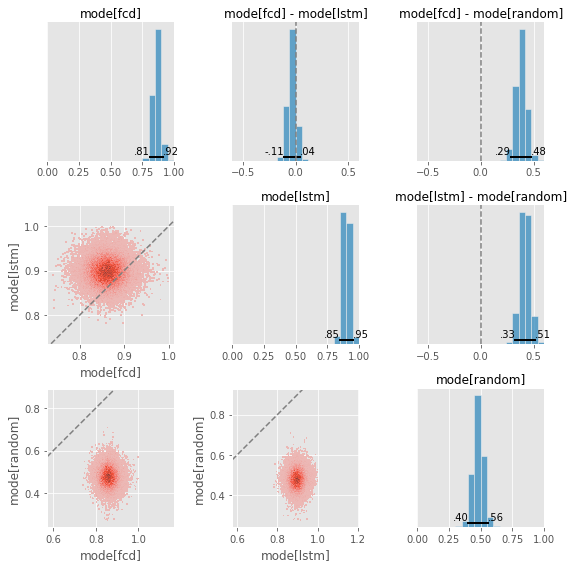

In [25]:
mode_comparison(accuracy_trace, ['fcd', 'lstm', 'random'], diag_xlim=(0, 1), comp_xlim=(-0.6, 0.6))

### Backchannels categorisation

In [26]:
_df = group_by_measurement.get_group('backchannels')
bc_data = {
    'n_parts': len(_df['part'].unique()),
    'n_models': len(_df['model'].unique()),
    'correct': _df.pivot_table(index='model', columns='part', values='value', aggfunc='sum'),
    'attempts': _df.pivot_table(index='model', columns='part', values='value', aggfunc='count'),
}

In [27]:
bc_trace = run_model(code=hierarchical_beta_code, data=bc_data)

adapting: iterations 4000 of 4000, elapsed 0:00:01, remaining 0:00:00
sampling: iterations 40000 of 40000, elapsed 0:00:06, remaining 0:00:00
sampling: iterations 40000 of 40000, elapsed 0:00:06, remaining 0:00:00


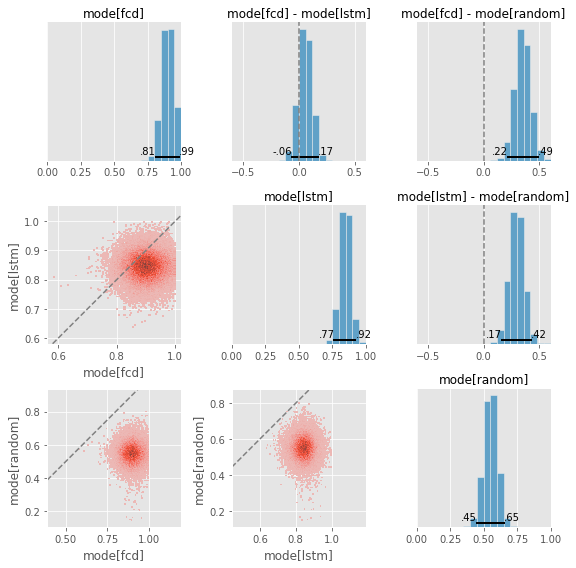

In [28]:
mode_comparison(bc_trace, ['fcd', 'lstm', 'random'], diag_xlim=(0, 1), comp_xlim=(-0.6, 0.6))

### Stability

In [29]:
stability_code = f"""
model {{
    for (m in 1:n_models) {{
        for (p in 1:n_parts) {{
            stability[m, p] ~ dgamma({gamma_template('mode[m]', 'sd[m]')})
        }}
        
        mode[m] ~ dgamma({gamma_template(1, 1)})
        sd[m] ~ dgamma({gamma_template(1, 1)})
    }}
}}
"""

In [30]:
_df = group_by_measurement.get_group('stability')
stability_data = {
    'n_parts': len(_df['part'].unique()),
    'n_models': len(_df['model'].unique()),
    'stability': _df.pivot(index='model', columns='part', values='value'),
}

In [31]:
stability_trace = run_model(code=stability_code, data=stability_data)

adapting: iterations 4000 of 4000, elapsed 0:00:00, remaining 0:00:00
sampling: iterations 40000 of 40000, elapsed 0:00:04, remaining 0:00:00


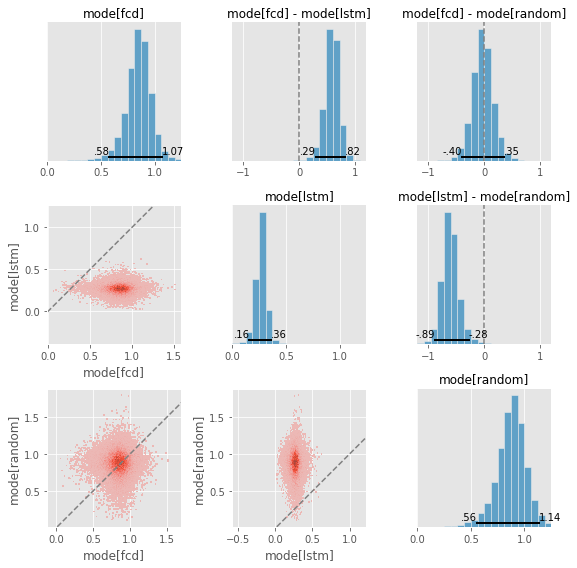

In [32]:
mode_comparison(stability_trace, ['fcd', 'lstm', 'random'], diag_xlim=(0, 1.25), comp_xlim=(-1.2, 1.2))

### Lag

In [33]:
lag_code = f"""
model {{
    for (i in 1:n_lags) {{
        lag[i] ~ dexp(1 / part_mean[models[i], part[i]])
    }}
    for (i in 1:n_models) {{
        for (j in 1:n_parts) {{
            part_mean[i, j] ~ dgamma({gamma_template('mode[i]', 'sd[i]')})
        }}
        
        mode[i] ~ dgamma({gamma_template(0.5, 1)})
        sd[i] ~ dgamma({gamma_template(1, 1)})
    }}
}}
"""

In [34]:
_df = group_by_measurement.get_group('lag')
lag_data = {
    'n_parts': len(_df['part'].unique()),
    'n_models': len(_df['model'].unique()),
    'n_lags': len(_df),
    'lag': _df['value'],
    'models': _df['model'].cat.codes + 1,
    'part': _df['part'].cat.codes + 1,
}

In [35]:
lag_trace = run_model(code=lag_code, data=lag_data)

adapting: iterations 4000 of 4000, elapsed 0:00:03, remaining 0:00:00
sampling: iterations 12880 of 40000, elapsed 0:00:09, remaining 0:00:20
sampling: iterations 19796 of 40000, elapsed 0:00:14, remaining 0:00:15
sampling: iterations 26692 of 40000, elapsed 0:00:19, remaining 0:00:10
sampling: iterations 40000 of 40000, elapsed 0:00:29, remaining 0:00:00
sampling: iterations 40000 of 40000, elapsed 0:00:29, remaining 0:00:00


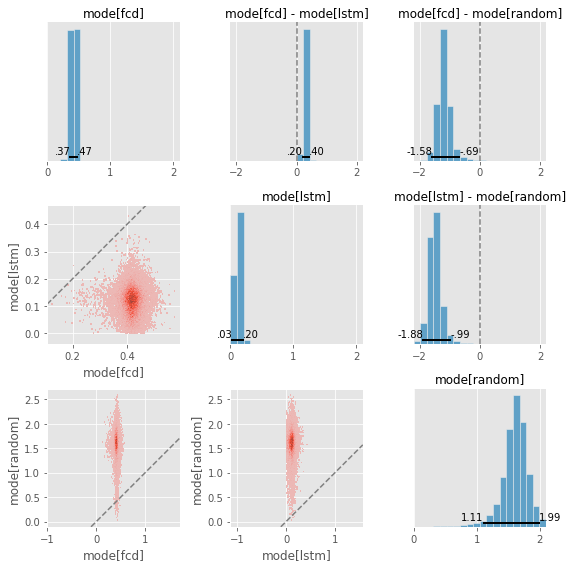

In [36]:
mode_comparison(lag_trace, ['fcd', 'lstm', 'random'], diag_xlim=(0, 2.1), comp_xlim=(-2.2, 2.2))

### FCD with default params vs. optimised FCD

In [37]:
traces = {
    'accuracy': accuracy_trace,
    'backchannels': bc_trace,
    'stability': stability_trace,
    'lag': lag_trace,
}

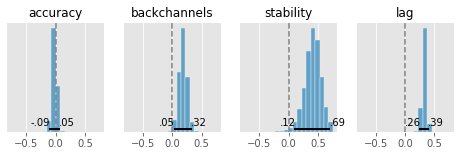

In [38]:
compare_two(['fcd', 'optimised_fcd'], traces, xlim=(-0.75, 0.75))

### LSTM vs. partial-LSTM

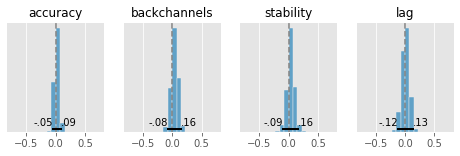

In [39]:
compare_two(['lstm', 'partial_lstm'], traces, xlim=(-0.75, 0.75))